##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Face Detection with MediaPipe Tasks

This notebook shows you how to use the MediaPipe Tasks Python API to detect faces in images.

## Preparation

Let's start with installing MediaPipe.

In [2]:
#!pip install mediapipe

  Using cached mediapipe-0.10.14-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached jax-0.4.28-py3-none-any.whl.metadata (23 kB)
  Using cached jaxlib-0.4.28-cp39-cp39-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached cffi-1.16.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached ml_dtypes-0.4.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached contourpy-1.2.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB

Then download an off-the-shelf model. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_detector#models) for more face detection models that you can use.

In [3]:
#!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

## Visualization utilities

To better demonstrate the Face Detector API, we have created a set of visualization tools that will be used in this colab. These will draw a bounding box around detected faces, as well as markers over certain detected points on the faces.

In [36]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = (bbox.origin_x, bbox.origin_y)
    end_point = (bbox.origin_x + bbox.width, bbox.origin_y + bbox.height) # bbox.width=bbox.height=543
    # Manually enlarge bounding_box
    center_point = ((start_point[0]+end_point[0])/2, (start_point[1]+end_point[1])/2)
    start_point = (int(center_point[0]-400), int(center_point[1]-400))
    end_point = (int(center_point[0]+400), int(center_point[1]+400))
    cropped_image = image[start_point[1]:end_point[1], start_point[0]:end_point[0]]

    # cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3) 
    # Draw keypoints
    # for keypoint in detection.keypoints:
    #   keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
    #                                                  width, height)
    #   color, thickness, radius = (0, 255, 0), 2, 2
    #   cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # # Draw label and score
    # category = detection.categories[0]
    # category_name = category.category_name
    # category_name = '' if category_name is None else category_name
    # probability = round(category.score, 2)
    # result_text = category_name + ' (' + str(probability) + ')'
    # text_location = (MARGIN + bbox.origin_x,
    #                  MARGIN + ROW_SIZE + bbox.origin_y)
    # cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
    #             FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return cropped_image

## Download test image

To demonstrate Face Detection, you can download a sample image using the following code. Credits: https://pixabay.com/photos/brother-sister-girl-family-boy-977170/

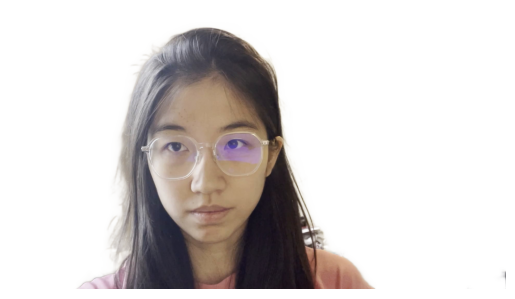

In [14]:
IMAGE_FILE = '/usr/project/xtmp/rz95/Telepresence/controlnet/matte_images/FOREGROUND_MATTE_1_68/IMG_7944_000.png'

import cv2
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread(IMAGE_FILE)

# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off') 
plt.show()

Optionally, you can upload your own image from your computer. To do this, uncomment the following code cell.

## Running inference and visualizing the results

The final step is to run face detection on your selected image. This involves creating your FaceDetector object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

You can check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_detector/python) to learn more about configuration options that this solution supports.

I0000 00:00:1716952509.569439 3381512 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1716952509.573650 3398437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/users/rz95/anaconda3/envs/tele/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


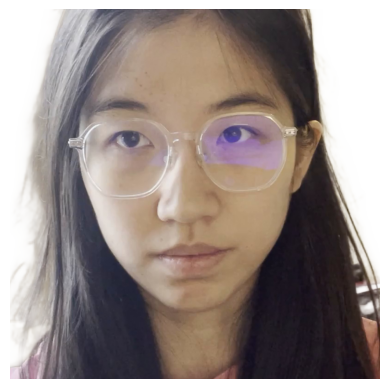

In [37]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
cropped_image = visualize(image_copy, detection_result)

cv2.imwrite('path/to/cropped_image.jpg', cropped_image)
plt.imshow(cropped_image)
plt.axis('off')  
plt.show()